In [1]:
library(survival)
library(ggplot2)
library(dplyr)
library(reshape2)
library(stringr)

Warning message:
“package ‘survival’ was built under R version 4.0.5”
Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘reshape2’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”


In [2]:
dir_fig = 'R_clogit/sigCategory_plats_v3/'

file_dir = 'combined_tables_missing/'

#pca_combined = TRUE
#pca_combined = FALSE
file_pca_all = 'pca_calculation/PC_data_ALL.tsv'
file_pca_pb = 'pca_calculation/PC_data_PB.tsv'
file_pca_ont = 'pca_calculation/PC_data_ONT.tsv'
#if (pca_combined) {
#    pca_comb_suff = ''
#    pca_comb_title = 'pca: comb'
#} else {pca_comb_suff = '_pcaSepPBONT'
#       pca_comb_title = 'pca: sep PB/ONT'}

# for LongTR
#q_suf = '_Q'
# for snoopsv
#q_suf = ''

filter_samples = FALSE
#filter_samples = TRUE
#file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/sv_missingness/samples_missingness_30.tsv'
#file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/sv_missingness/samples_missingness_40.tsv'
file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/sv_missingness/samples_missingness_50.tsv'
# TR based missing
#file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/samples_missingness_50.tsv'

#pca_flt_name = 'SQ20_SAMPLES'
pca_flt_name = 'SQ30_SAMPLES'
#pca_flt_name = 'SQ40_SAMPLES'
#pca_flt_name = 'SQ50_SAMPLES'
#pca_flt_name = 'SQ70_SAMPLES'

#pca_mode = 'reg'
pca_mode = 'null'

#use_gw_cov = FALSE
use_gw_cov = TRUE
use_gw_cov_ooc = FALSE
#use_gw_cov_ooc = TRUE
gw_suf = ''
gw_suf_ooc = ''
gw_var = ''
if (use_gw_cov) {
    gw_suf = '_useGWB'
    if (use_gw_cov_ooc) {
        gw_suf_ooc = '_OOC'
    }
    gw_var = 'count_genomewide'
}

In [3]:
### clean features
fts = c('PLIp9_cds + PLIp9_utr')
fts_labels = c('pLI≥.9, exonic')
fts_cats = c('pLI≥.9')
fts_func = c('exonic')
fts_col_names = c('pli_genes_exonic')

#plat_cats = c('lr', 'il', 'lr_il_lrgt', 'lr_il_ilgt', 'lr + lr_il_lrgt', 'il + lr_il_ilgt', 'lr + lr_il_lrgt + il')
#plat_cats_labels = c('LR only', 'IL only', 'LR intrs. IL, LR GT', 'LR intrs. IL, IL GT', 'LR discovered', 'IL discovered', 'LR plus IL')
#plat_cats = c('lr + lr_il_lrgt', 'il + lr_il_ilgt', 'lr + lr_il_lrgt + il')
#plat_cats_labels = c('LR only + LR/IL', 'IL only + LR/IL', 'LR only + LR/IL + IL only')

### lr genotypes for LR_IL, add 'LR/IL + IL only'
#plat_cats = c('lr', 'lr_il_lrgt', 'il', 'lr + lr_il_lrgt + il', 'lr_il_lrgt + il')
#plat_cats_labels = c('LR only', 'LR/IL', 'IL only', 'LR only + LR/IL + IL only', 'LR/IL + IL only')
### il genotypes for LR_IL, add 'LR/IL + IL only'
plat_cats = c('lr', 'lr_il_ilgt', 'il', 'lr + lr_il_ilgt + il', 'lr_il_ilgt + il')
plat_cats_labels = c('LR only', 'LR/IL', 'IL only', 'LR only + LR/IL + IL only', 'LR/IL + IL only')

In [4]:
get_pval_char <- function(pval) {
    if (pval>0.05) {return('')}
    if ((pval<0.05) && (pval>0.01)) {return('*')}
    else if ((pval<0.01) && (pval>0.001)) {return('**')}
    else {return('***')}
}

In [5]:
#prs_mode = 'sbayesr'
prs_mode = 'prscs'
#file_suf = 'SQ70_SAMPLES_AD2_SAMPLES'
#file_suf = 'SQ20_SAMPLES_AD2_SAMPLES'
file_suf = 'SQ30_SAMPLES_AD2_SAMPLES'
#file_suf = 'SQ40_SAMPLES_AD2_SAMPLES'
#file_suf = 'SQ50_SAMPLES_AD2_SAMPLES'
#file_suf = 'SQ60_SAMPLES_AD2_SAMPLES'
#file_suf = 'SQ70_SAMPLES_AD2_SAMPLES_HP12'
#file_suf = 'SQ70_SAMPLES_AD2_SAMPLES_NCOM'
#file_suf = 'SQ50_SAMPLES_AD2_SAMPLES'
file_suf_trmissing = '25'
#file_suf_trmissing = '20'
#file_suf_trmissing = '15'
if (prs_mode == 'sbayesr') {
    file_main = paste0(file_dir, 'combined_svs_trs_snvs_prs_pc_sbayesr_', file_suf, '_DELINS_GW_plat', '_TRmissingness', file_suf_trmissing, '_fltHomPol_famGT.csv')
} else if (prs_mode == 'prscs') {
    file_main = paste0(file_dir, 'combined_svs_trs_snvs_prs_pc_prscs_', file_suf, '_DELINS_GW_plat', '_TRmissingness', file_suf_trmissing, '_fltHomPol_famGT.csv')}

df_main <- read.table(file_main, header = TRUE, sep = ",")
#df_main['count_PLIp9_nonLOF_DEV_BR_10_cds'] = df_main[,'count_PLIp9_DEV_BR_GENE_10_cds'] - df_main[,'count_PLIp9_LOF_DEV_BR_10_cds']
df_main[,'Platform'] <- as.factor(df_main[,'Platform'])
df_main[,'sex'] <- as.factor(df_main[,'sex'])
dim(df_main)
df_main

[1]  243 5571

fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,⋯,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_del,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_ins,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q_del,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q_ins,PRS_ASD_Z,PRS_SCZ_Z,PRS_EDU_Z,count_dnlof_inhlof
<chr>,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627126,-0.005607061,⋯,0,0,0,0,0,0,-0.971701072,-0.510485305,0.82162924,0
F0026,REACH000026,ASD,Male,1,trio,1,0,0.095363540,-0.045229620,⋯,0,0,0,0,0,0,0.303644763,0.817056455,0.06312390,1
F0058,REACH000058,ASD,Male,1,trio,1,1,0.002421759,-0.009216429,⋯,0,0,0,0,0,0,0.595643472,-0.305436874,1.94303491,2
F0065,REACH000065,ASD,Male,1,trio,1,0,0.252773800,0.107932900,⋯,0,0,0,0,0,0,1.166191828,0.943709479,-2.78896425,1
F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785250,0.038064880,⋯,0,0,0,0,0,0,0.703902177,-0.152554399,0.06482359,0
F0078,REACH000089,ASD,Female,1,trio,2,0,0.049879690,0.047204300,⋯,0,0,0,0,0,0,0.384605619,0.209070495,0.16440487,0
F0081,REACH000092,ASD,Female,1,trio,1,1,-0.028510680,-0.001001894,⋯,0,0,0,0,0,0,-0.898010204,-0.994547648,0.53088874,1
F0081,REACH000095,CON,Female,1,trio,1,1,-0.030440730,-0.002736118,⋯,0,0,0,0,0,0,-1.036073363,-1.487948561,0.29231934,1
F0083,REACH000097,ASD,Male,1,trio,1,0,0.095793110,0.052887850,⋯,0,0,0,0,0,0,0.817923575,-0.003587407,-0.08546761,1


In [6]:
# SV pca data
# using combined samples for pca
df_sv_pca_comb <- read.table(file_pca_all, header = TRUE, sep = "\t")
df_sv_pca_comb <- df_sv_pca_comb %>% select(SAMPLE, Platform, everything())

pcs = paste0('PC', 1:10, '_', pca_flt_name)
for (pc in pcs) {
    col_name = paste0(pc, '_comb')
    df_main[,col_name] <- df_sv_pca_comb[,pc]
}

# using separate PB/ONT samples for pca
df_pca_pb <- read.table(file_pca_pb, header = TRUE, sep = "\t")
df_pca_ont <- read.table(file_pca_ont, header = TRUE, sep = "\t")
#dim(df_pca_pb)
#dim(df_pca_ont)
# bring the SAMPLE and Platform column to the front
df_pca_pb <- df_pca_pb %>% select(SAMPLE, Platform, everything())
df_pca_ont <- df_pca_ont %>% select(SAMPLE, Platform, everything())
#dim(df_pca_pb)
#dim(df_pca_ont)
df_sv_pca <- rbind(df_pca_pb, df_pca_ont)
#dim(df_sv_pca)
# order the dataframe with the order of samples in df_main
df_sv_pca$SAMPLE <- factor(df_sv_pca$SAMPLE, levels=df_main$iid)
df_sv_pca <- arrange(df_sv_pca, SAMPLE)

#print('df_sv_pca:')
#df_sv_pca

pcs = paste0('PC', 1:10, '_', pca_flt_name)
for (pc in pcs) {
    df_main[,pc] <- df_sv_pca[,pc]
}
dim(df_main)

[1]  243 5591

In [7]:
### subset the main df to filter high missingness SVs

df_sam_missing = read.table(file_sam_missing, header = TRUE, sep = "\t", col.names = c('SAMPLE', 'PLAT'))
# for TR based filters
#df_sam_missing = read.table(file_sam_missing, header = TRUE, sep = "\t", col.names = c('SAMPLE'))
dim(df_sam_missing)

tmp = unlist(strsplit(file_sam_missing, '_'))
sample_missingness = unlist(strsplit(tmp[[length(tmp)]], '.tsv'))[[1]]
sample_missingness

flt_sam_suff = '_allSamples'
flt_sam_title = 'all samples'
if (filter_samples) {
    flt_sam_suff = paste0('_filterSamples', sample_missingness)
    flt_sam_title = paste('sample MS≤', as.double(sample_missingness)/100)
    # subset samples based on missingness
    df_main <- df_main[df_main$iid %in% df_sam_missing$SAMPLE,]
    # eliminate samples with low family members
    ##t = table(df_main$fid)
    ##df_main['fid_count'] = sapply(df_main$fid, function(x) t[x])
    ##df_main = df_main[df_main$fid_count>=3,]
}
dim(df_main)


df_main_ont = df_main %>% filter(Platform == 'ONT')
df_main_pb = df_main %>% filter(Platform == 'PB')
print(dim(df_main_ont))
print(dim(df_main_pb))

[1] 213   2

[1] "50"

[1]  243 5591

[1]  101 5591
[1]  142 5591


In [8]:
# make extra SV PCA variables
# separate PCs
pca_vars = paste0('PC', 1:10, '_', pca_flt_name)
pca_var_str = paste(pca_vars, collapse=' + ')
# combined PCs
pca_vars_comb = paste0('PC', 1:10, '_', pca_flt_name, '_comb')
pca_var_str_comb = paste(pca_vars_comb, collapse=' + ')
if (pca_mode == 'reg') {
    pca_suff = paste0('pca_', pca_flt_name)
} else if (pca_mode == 'null') {
    pca_suff = paste0('pca_', 'null')
    pca_var_str = ''
    pca_var_str_comb = ''
}

pca_var_str
pca_var_str_comb
pca_suff

[1] ""

[1] ""

[1] "pca_null"

In [9]:
### SVs All
PRINT_INFO = TRUE
#PRINT_INFO = FALSE
SHOW_FORMULA = TRUE

ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
SEs = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
fts_loop = c()
fts_labels_loop = c()
plat_cats_loop = c()
plat_cats_labels_loop = c()
for (i_ft in 1:length(fts)) {
    ft = fts[i_ft]
    ft_label = fts_labels[i_ft]
    # make vector of features
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    print('this ft:')
    print(ft)
    for (i_plat_cat in 1:length(plat_cats)) {
        plat_cat = plat_cats[i_plat_cat]
        plat_cat_label = plat_cats_labels[i_plat_cat]
        print('plat_cat:')
        print(plat_cat)

        # make loop fts & plats
        fts_loop = c(fts_loop, ft)
        fts_labels_loop = c(fts_labels_loop, ft_label)
        plat_cats_loop = c(plat_cats_loop, plat_cat)
        plat_cats_labels_loop = c(plat_cats_labels_loop, plat_cat_label)
        
        # make vector of platforms
        pl_tmp = unlist(strsplit(plat_cat, split='+', fixed=TRUE)) # split vars with +
        pl_tmp = str_trim(pl_tmp) # trim spaces
        #print('pl_tmp:')
        #print(pl_tmp)

        # make the sum of burden variables
        var_tmp = c()
        for (ft_ in ft_tmp) {
            var_tmp = c(var_tmp, paste0('count_', ft_, '_', pl_tmp))
        }
        print(var_tmp)

        new_df = df_main
        new_df['new_var'] = 0
        for (var_ in var_tmp) {
            new_df['new_var'] = new_df['new_var'] + df_main[var_]
        }
        var = 'new_var'

        #if (plat_cat == 'lr + lr_il_ilgt + il') {
        if (plat_cat == 'lr_il_ilgt + il') {
            #print('data for plat:')
            #print(plat_cat)
            #print(new_df[c('iid', 'new_var')])
        }

        ### make out of category genomewide burden
        gw_var_ooc = ''
        if (use_gw_cov) {
            gw_var_ooc = 'gw_ooc'
            new_df[gw_var_ooc] = 0
            for (pl_ in pl_tmp) {
                var_gw = paste0('count_genomewide_', pl_)
                new_df[gw_var_ooc] = new_df[gw_var_ooc] + new_df[var_gw]
            }
        }

        null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str_comb, '+', gw_var_ooc,
                              '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        if (SHOW_FORMULA) {
            print(null_formula)
            SHOW_FORMULA = FALSE
        }
        
        sum_case = sum(new_df[new_df$Phenotype==1,][,var])
        sum_control = sum(new_df[new_df$Phenotype==0,][,var])
        sum_cases = c(sum_cases, sum_case)
        sum_controls = c(sum_controls, sum_control)
        
        model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str_comb, '+', gw_var_ooc,
                                         '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
            
        null_model <- clogit(null_formula, data = new_df)
        #print(summary(null_model))
        
        clogit_model <- clogit(model_formula, data = new_df)
        #print(summary(clogit_model))
        #print(str(summary(clogit_model)))
        OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
        OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
        OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
        log_OR = summary(clogit_model)$coefficients[var, 'coef']
        log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
        log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
        SE = summary(clogit_model)$coefficients[var, 'se(coef)']
        pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
        ORs = c(ORs, OR)
        ORs_plus = c(ORs_plus, OR_plus)
        ORs_minus = c(ORs_minus, OR_minus)
        log_ORs = c(log_ORs, log_OR)
        log_ORs_plus = c(log_ORs_plus, log_OR_plus)
        log_ORs_minus = c(log_ORs_minus, log_OR_minus)
        SEs = c(SEs, SE)
        pvals = c(pvals, pval)
            
        ano <- anova(null_model, clogit_model, test='LRT')
        ano_pval = ano$"Pr(>|Chi|)"[2]
        ano_pvals = c(ano_pvals, ano_pval)
    }
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('SEs:')
    print(SEs)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data = data.frame('fts' = fts_loop, 'fts_labels' = fts_labels_loop, 'plat' = plat_cats_loop, 'plat_labels' = plat_cats_labels_loop,
                     'log_ORs' = log_ORs, 'log_ORs_plus' = log_ORs_plus, 'log_ORs_minus' = log_ORs_minus, 
                     'ano_pval' = ano_pvals, 'SEs' = SEs,
                     'sum_case_con' = sum_case_controls)

### write burden test tables
this_cols = c('fts_labels', 'plat_labels', 'log_ORs', 'log_ORs_plus', 'log_ORs_minus', 'ano_pval', 'SEs')
new_cols = c('Category', 'platform', 'log OR', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value', 'standard error')
this_data_out = my_data[this_cols]
# formating the columns with number of digits
for (i_col in 3:length(this_cols)) {
    this_col = this_cols[i_col]
    this_data_out[this_col] = format(this_data_out[this_col], digits = 4, nsmall = 2)
}
colnames(this_data_out) <- new_cols
print(this_data_out)
file_out = paste0(dir_fig, 'burden_tests_table_svs.tsv')
print(file_out)
write.table(this_data_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

[1] "this ft:"
[1] "PLIp9_cds + PLIp9_utr"
[1] "plat_cat:"
[1] "lr"
[1] "count_PLIp9_cds_lr" "count_PLIp9_utr_lr"
Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    +gw_ooc + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10 + strata(fid)
[1] "plat_cat:"
[1] "lr_il_ilgt"
[1] "count_PLIp9_cds_lr_il_ilgt" "count_PLIp9_utr_lr_il_ilgt"
[1] "plat_cat:"
[1] "il"
[1] "count_PLIp9_cds_il" "count_PLIp9_utr_il"
[1] "plat_cat:"
[1] "lr + lr_il_ilgt + il"
[1] "count_PLIp9_cds_lr"         "count_PLIp9_cds_lr_il_ilgt"
[3] "count_PLIp9_cds_il"         "count_PLIp9_utr_lr"        
[5] "count_PLIp9_utr_lr_il_ilgt" "count_PLIp9_utr_il"        
[1] "plat_cat:"
[1] "lr_il_ilgt + il"
[1] "count_PLIp9_cds_lr_il_ilgt" "count_PLIp9_cds_il"        
[3] "count_PLIp9_utr_lr_il_ilgt" "count_PLIp9_utr_il"        
[1] "ORs:"
[1] 0.9440191 1.3536809 1.9160114 1.2885796 1.4669916
[1] "ORs_plus:"
[1] 1.653455 2.098145 4.466025 1.764577 2.189626
[1] "ORs_minus:"
[1] 0.5389757 0.873367

In [10]:
### SVs ONT
PRINT_INFO = TRUE
#PRINT_INFO = FALSE
SHOW_FORMULA = TRUE

ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
SEs = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
fts_loop = c()
fts_labels_loop = c()
plat_cats_loop = c()
plat_cats_labels_loop = c()
for (i_ft in 1:length(fts)) {
    ft = fts[i_ft]
    ft_label = fts_labels[i_ft]
    # make vector of features
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    print('this ft:')
    print(ft)
    for (i_plat_cat in 1:length(plat_cats)) {
        plat_cat = plat_cats[i_plat_cat]
        plat_cat_label = plat_cats_labels[i_plat_cat]
        print('plat_cat:')
        print(plat_cat)

        # make loop fts & plats
        fts_loop = c(fts_loop, ft)
        fts_labels_loop = c(fts_labels_loop, ft_label)
        plat_cats_loop = c(plat_cats_loop, plat_cat)
        plat_cats_labels_loop = c(plat_cats_labels_loop, plat_cat_label)
        
        # make vector of platforms
        pl_tmp = unlist(strsplit(plat_cat, split='+', fixed=TRUE)) # split vars with +
        pl_tmp = str_trim(pl_tmp) # trim spaces
        #print('pl_tmp:')
        #print(pl_tmp)

        # make the sum of burden variables
        var_tmp = c()
        for (ft_ in ft_tmp) {
            var_tmp = c(var_tmp, paste0('count_', ft_, '_', pl_tmp))
        }
        print(var_tmp)

        new_df = df_main_ont
        new_df['new_var'] = 0
        for (var_ in var_tmp) {
            new_df['new_var'] = new_df['new_var'] + df_main_ont[var_]
        }
        var = 'new_var'

        #if (plat_cat == 'lr + lr_il_ilgt + il') {
        if (plat_cat == 'lr_il_ilgt + il') {
            #print('data for plat:')
            #print(plat_cat)
            #print(new_df[c('iid', 'new_var')])
        }

        ### make out of category genomewide burden
        gw_var_ooc = ''
        if (use_gw_cov) {
            gw_var_ooc = 'gw_ooc'
            new_df[gw_var_ooc] = 0
            for (pl_ in pl_tmp) {
                var_gw = paste0('count_genomewide_', pl_)
                new_df[gw_var_ooc] = new_df[gw_var_ooc] + new_df[var_gw]
            }
        }

        null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str_comb, '+', gw_var_ooc,
                              '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        if (SHOW_FORMULA) {
            print(null_formula)
            SHOW_FORMULA = FALSE
        }
        
        sum_case = sum(new_df[new_df$Phenotype==1,][,var])
        sum_control = sum(new_df[new_df$Phenotype==0,][,var])
        sum_cases = c(sum_cases, sum_case)
        sum_controls = c(sum_controls, sum_control)
        
        model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str_comb, '+', gw_var_ooc,
                                         '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
            
        null_model <- clogit(null_formula, data = new_df)
        #print(summary(null_model))
        
        clogit_model <- clogit(model_formula, data = new_df)
        #print(summary(clogit_model))
        #print(str(summary(clogit_model)))
        OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
        OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
        OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
        log_OR = summary(clogit_model)$coefficients[var, 'coef']
        log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
        log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
        SE = summary(clogit_model)$coefficients[var, 'se(coef)']
        pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
        ORs = c(ORs, OR)
        ORs_plus = c(ORs_plus, OR_plus)
        ORs_minus = c(ORs_minus, OR_minus)
        log_ORs = c(log_ORs, log_OR)
        log_ORs_plus = c(log_ORs_plus, log_OR_plus)
        log_ORs_minus = c(log_ORs_minus, log_OR_minus)
        SEs = c(SEs, SE)
        pvals = c(pvals, pval)
            
        ano <- anova(null_model, clogit_model, test='LRT')
        ano_pval = ano$"Pr(>|Chi|)"[2]
        ano_pvals = c(ano_pvals, ano_pval)
    }
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('SEs:')
    print(SEs)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_all_ont = cbind(my_data, data.frame('log_ORs_ont' = log_ORs, 'log_ORs_plus_ont' = log_ORs_plus, 'log_ORs_minus_ont' = log_ORs_minus, 
                     'ano_pval_ont' = ano_pvals, 'SEs_ont' = SEs,
                     'sum_case_con_ont' = sum_case_controls))

[1] "this ft:"
[1] "PLIp9_cds + PLIp9_utr"
[1] "plat_cat:"
[1] "lr"
[1] "count_PLIp9_cds_lr" "count_PLIp9_utr_lr"
Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    +gw_ooc + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10 + strata(fid)
[1] "plat_cat:"
[1] "lr_il_ilgt"
[1] "count_PLIp9_cds_lr_il_ilgt" "count_PLIp9_utr_lr_il_ilgt"
[1] "plat_cat:"
[1] "il"
[1] "count_PLIp9_cds_il" "count_PLIp9_utr_il"
[1] "plat_cat:"
[1] "lr + lr_il_ilgt + il"
[1] "count_PLIp9_cds_lr"         "count_PLIp9_cds_lr_il_ilgt"
[3] "count_PLIp9_cds_il"         "count_PLIp9_utr_lr"        
[5] "count_PLIp9_utr_lr_il_ilgt" "count_PLIp9_utr_il"        
[1] "plat_cat:"
[1] "lr_il_ilgt + il"
[1] "count_PLIp9_cds_lr_il_ilgt" "count_PLIp9_cds_il"        
[3] "count_PLIp9_utr_lr_il_ilgt" "count_PLIp9_utr_il"        
[1] "ORs:"
[1] 1.1304438 0.9668017 0.9774218 1.1756174 1.0155783
[1] "ORs_plus:"
[1] 2.779592 2.085272 6.335288 2.040253 2.065580
[1] "ORs_minus:"
[1] 0.4597450 0.448241

In [11]:
### SVs PB
PRINT_INFO = TRUE
#PRINT_INFO = FALSE
SHOW_FORMULA = TRUE

ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
SEs = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
fts_loop = c()
fts_labels_loop = c()
plat_cats_loop = c()
plat_cats_labels_loop = c()
for (i_ft in 1:length(fts)) {
    ft = fts[i_ft]
    ft_label = fts_labels[i_ft]
    # make vector of features
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    print('this ft:')
    print(ft)
    for (i_plat_cat in 1:length(plat_cats)) {
        plat_cat = plat_cats[i_plat_cat]
        plat_cat_label = plat_cats_labels[i_plat_cat]
        print('plat_cat:')
        print(plat_cat)

        # make loop fts & plats
        fts_loop = c(fts_loop, ft)
        fts_labels_loop = c(fts_labels_loop, ft_label)
        plat_cats_loop = c(plat_cats_loop, plat_cat)
        plat_cats_labels_loop = c(plat_cats_labels_loop, plat_cat_label)
        
        # make vector of platforms
        pl_tmp = unlist(strsplit(plat_cat, split='+', fixed=TRUE)) # split vars with +
        pl_tmp = str_trim(pl_tmp) # trim spaces
        #print('pl_tmp:')
        #print(pl_tmp)

        # make the sum of burden variables
        var_tmp = c()
        for (ft_ in ft_tmp) {
            var_tmp = c(var_tmp, paste0('count_', ft_, '_', pl_tmp))
        }
        print(var_tmp)

        new_df = df_main_pb
        new_df['new_var'] = 0
        for (var_ in var_tmp) {
            new_df['new_var'] = new_df['new_var'] + df_main_pb[var_]
        }
        var = 'new_var'

        #if (plat_cat == 'lr + lr_il_ilgt + il') {
        if (plat_cat == 'lr_il_ilgt + il') {
            #print('data for plat:')
            #print(plat_cat)
            #print(new_df[c('iid', 'new_var')])
        }

        ### make out of category genomewide burden
        gw_var_ooc = ''
        if (use_gw_cov) {
            gw_var_ooc = 'gw_ooc'
            new_df[gw_var_ooc] = 0
            for (pl_ in pl_tmp) {
                var_gw = paste0('count_genomewide_', pl_)
                new_df[gw_var_ooc] = new_df[gw_var_ooc] + new_df[var_gw]
            }
        }

        null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str_comb, '+', gw_var_ooc,
                              '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        if (SHOW_FORMULA) {
            print(null_formula)
            SHOW_FORMULA = FALSE
        }
        
        sum_case = sum(new_df[new_df$Phenotype==1,][,var])
        sum_control = sum(new_df[new_df$Phenotype==0,][,var])
        sum_cases = c(sum_cases, sum_case)
        sum_controls = c(sum_controls, sum_control)
        
        model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str_comb, '+', gw_var_ooc,
                                         '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
            
        null_model <- clogit(null_formula, data = new_df)
        #print(summary(null_model))
        
        clogit_model <- clogit(model_formula, data = new_df)
        #print(summary(clogit_model))
        #print(str(summary(clogit_model)))
        OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
        OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
        OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
        log_OR = summary(clogit_model)$coefficients[var, 'coef']
        log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
        log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
        SE = summary(clogit_model)$coefficients[var, 'se(coef)']
        pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
        ORs = c(ORs, OR)
        ORs_plus = c(ORs_plus, OR_plus)
        ORs_minus = c(ORs_minus, OR_minus)
        log_ORs = c(log_ORs, log_OR)
        log_ORs_plus = c(log_ORs_plus, log_OR_plus)
        log_ORs_minus = c(log_ORs_minus, log_OR_minus)
        SEs = c(SEs, SE)
        pvals = c(pvals, pval)
            
        ano <- anova(null_model, clogit_model, test='LRT')
        ano_pval = ano$"Pr(>|Chi|)"[2]
        ano_pvals = c(ano_pvals, ano_pval)
    }
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('SEs:')
    print(SEs)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_all_ont_pb = cbind(my_data_all_ont, data.frame('log_ORs_pb' = log_ORs, 'log_ORs_plus_pb' = log_ORs_plus, 'log_ORs_minus_pb' = log_ORs_minus, 
                     'ano_pval_pb' = ano_pvals, 'SEs_pb' = SEs,
                     'sum_case_con_pb' = sum_case_controls))

[1] "this ft:"
[1] "PLIp9_cds + PLIp9_utr"
[1] "plat_cat:"
[1] "lr"
[1] "count_PLIp9_cds_lr" "count_PLIp9_utr_lr"
Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    +gw_ooc + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10 + strata(fid)
[1] "plat_cat:"
[1] "lr_il_ilgt"
[1] "count_PLIp9_cds_lr_il_ilgt" "count_PLIp9_utr_lr_il_ilgt"
[1] "plat_cat:"
[1] "il"
[1] "count_PLIp9_cds_il" "count_PLIp9_utr_il"
[1] "plat_cat:"
[1] "lr + lr_il_ilgt + il"
[1] "count_PLIp9_cds_lr"         "count_PLIp9_cds_lr_il_ilgt"
[3] "count_PLIp9_cds_il"         "count_PLIp9_utr_lr"        
[5] "count_PLIp9_utr_lr_il_ilgt" "count_PLIp9_utr_il"        
[1] "plat_cat:"
[1] "lr_il_ilgt + il"
[1] "count_PLIp9_cds_lr_il_ilgt" "count_PLIp9_cds_il"        
[3] "count_PLIp9_utr_lr_il_ilgt" "count_PLIp9_utr_il"        
[1] "ORs:"
[1] 0.8224056 1.7847555 2.0921343 1.5407198 1.8670260
[1] "ORs_plus:"
[1] 2.377617 3.699749 7.403453 2.528144 3.484049
[1] "ORs_minus:"
[1] 0.2844659 0.860964

In [12]:
my_data_all_ont_pb['wt_ont'] = 1 / (my_data_all_ont_pb$SEs_ont^2)
my_data_all_ont_pb['wt_pb'] = 1 / (my_data_all_ont_pb$SEs_pb^2)
my_data_all_ont_pb['se_meta'] = sqrt(1 / (my_data_all_ont_pb['wt_ont'] + my_data_all_ont_pb['wt_pb']))
my_data_all_ont_pb['log_ORs_meta'] = ((my_data_all_ont_pb['log_ORs_ont']*my_data_all_ont_pb['wt_ont'] + 
                                          my_data_all_ont_pb['log_ORs_pb']*my_data_all_ont_pb['wt_pb']) / 
                                         (my_data_all_ont_pb['wt_ont'] + my_data_all_ont_pb['wt_pb']))
my_data_all_ont_pb['log_ORs_plus_meta'] = my_data_all_ont_pb['log_ORs_meta'] + my_data_all_ont_pb['se_meta']
my_data_all_ont_pb['log_ORs_minus_meta'] = my_data_all_ont_pb['log_ORs_meta'] - my_data_all_ont_pb['se_meta']
my_data_all_ont_pb['Z_meta'] = my_data_all_ont_pb['log_ORs_meta'] / my_data_all_ont_pb['se_meta']
my_data_all_ont_pb = my_data_all_ont_pb[!is.na(my_data_all_ont_pb['Z_meta']),]
my_data_all_ont_pb['ano_pval_meta'] = sapply(my_data_all_ont_pb['Z_meta'], function(x) 2 * (1 - pnorm(abs(x))))

[1] "R_clogit/sigCategory_plats_v3/pli_genes_exonic_SVs_burden_platform_pca_null_allSamples_SQ30_SAMPLES_AD2_SAMPLES_useGWB.png"


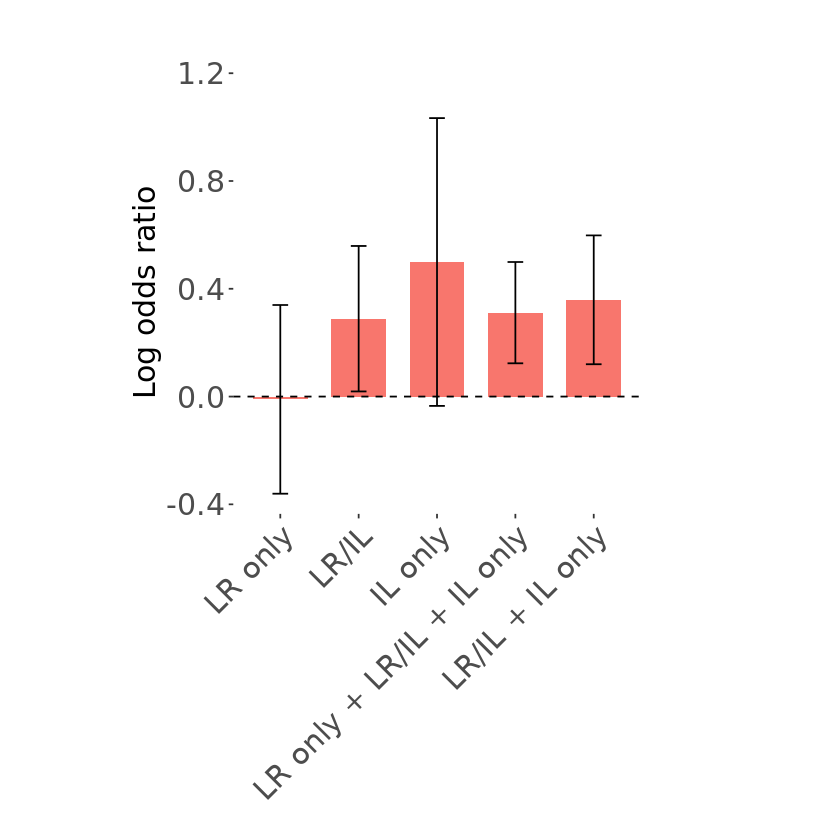

In [13]:
# plot SVs
fig_base = paste0(fts_col_names[1], '_SVs_burden_platform_', pca_suff, flt_sam_suff, '_', file_suf, gw_suf, gw_suf_ooc)
#title = paste0(pca_suff, ', ', flt_sam_title)
title = ''

size_txt = 18
size_sig = 8
ylim_min = -0.1
ylim_max = 1.5

fig_name = paste0(dir_fig, fig_base, ".png")

my_data_all_ont_pb$plat_labels <- factor(my_data_all_ont_pb$plat_labels, levels = plat_cats_labels_loop)

sig <- sapply(my_data_all_ont_pb$ano_pval_meta, get_pval_char)
my_data_all_ont_pb$sig = sig

base <- ggplot(my_data_all_ont_pb, aes(x = plat_labels, y = log_ORs_meta, fill = 'ref', ymin=log_ORs_minus_meta , ymax=log_ORs_plus_meta)) +
  geom_bar(stat = "identity", width = 0.7) +
  geom_errorbar(aes(ymin = log_ORs_minus_meta, ymax = log_ORs_plus_meta), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus_meta+0.1), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = title) +
  theme(axis.text=element_text(size=size_txt),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1., size=size_txt),
        # , color=color_vec
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt), 
        #legend.position = c(1.15, 0.8),
        legend.position = 'none',
        legend.text = element_text(size=size_txt-5),
        legend.title = element_text(size=size_txt),
        plot.margin = margin(20, 120, 20, 80) # Add margins: top, right, bottom, left (in points)
        ) +
  #scale_x_discrete(limits=x_main, labels=x_main) 
  #+
  #scale_fill_discrete(name = 'Subjects', labels = c("combined", "SNV/indel non-carriers"), values = c("red", "green")) + 
  #scale_fill_discrete(name = '', labels = c("ONT", "PB", "ONT+PB", "META"))
  #scale_fill_discrete(name = '', labels = c("ONT", "PB", "META"))
  scale_fill_discrete(name = '')
  #scale_fill_manual(name = 'Subjects', labels = c("combined", "excluding case subjects with dnLOF, dnMIS and InhLOF SNVs/indels"), values=c("khaki", "indianred1")) +

#if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(ylim_min, 2))}
#base <- base + ylim(c(ylim_min, ylim_max))

print(fig_name)
print(base)
ggsave(fig_name, width = 10, height = 8)

In [15]:
my_data_all_ont_pb

,fts,fts_labels,plat,plat_labels,log_ORs,log_ORs_plus,log_ORs_minus,ano_pval,SEs,sum_case_con,⋯,sum_case_con_pb,wt_ont,wt_pb,se_meta,log_ORs_meta,log_ORs_plus_meta,log_ORs_minus_meta,Z_meta,ano_pval_meta,sig
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>",<chr>
1,PLIp9_cds + PLIp9_utr,"pLI≥.9, exonic",lr,LR only,-0.1727934,0.2579314,-0.6035181,0.68796888,0.4307248,20/37,⋯,3/11,2.131017,0.982281,0.5667475,0.1012219,0.6679694,-0.46552565,0.1786013,0.85825074,
2,PLIp9_cds + PLIp9_utr,"pLI≥.9, exonic",lr_il_ilgt,LR/IL,0.4305728,0.7230440,0.1381016,0.12850476,0.2924712,69/102,⋯,27/51,4.189787,4.059444,0.3481715,0.4334597,0.7816312,0.08528816,1.2449602,0.21314638,
3,PLIp9_cds + PLIp9_utr,"pLI≥.9, exonic",il,IL only,0.6502456,1.0820153,0.2184759,0.12046487,0.4317697,46/83,⋯,38/73,1.099741,2.405280,0.5341395,0.4994054,1.0335448,-0.03473410,0.9349719,0.34980281,
4,PLIp9_cds + PLIp9_utr,"pLI≥.9, exonic",lr + lr_il_ilgt + il,LR only + LR/IL + IL only,0.4173353,0.6462858,0.1883848,0.05993989,0.2289505,135/222,⋯,68/135,5.511309,8.065268,0.2713969,0.5019017,0.7732986,0.23050479,1.8493273,0.06441056,
5,PLIp9_cds + PLIp9_utr,"pLI≥.9, exonic",lr_il_ilgt + il,LR/IL + IL only,0.5436264,0.7997938,0.2874589,0.02673140,0.2561674,115/185,⋯,65/124,4.944963,7.068561,0.2885126,0.5322553,0.8207679,0.24374267,1.8448250,0.06506299,


In [ ]:
### make the burden test table
sub_fts_out = c('intergenic',
            'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 
            'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
sub_fts_col_names_out = c('intergenic', 
                  'lowpli_genes_intronic', 'lowpli_genes_exonic', 
                  'pli_genes_intronic', 'pli_genes_exonic', 
                  'fetal_brain_genes_intronic', 'fetal_brain_genes_exonic')

gw_var_sv = 'count_genomewide'
#gw_var_tr = paste0('count_ZS', zs_thr, '_genomewide_SUPP', supp_thr, '_Q')

cols_out = c('fid','iid','Phenotype','sex','MEAN_COVERAGE','Platform','rel','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
             'count_dnlof_inhlof','PRS_ASD_Z', gw_var_sv)#, gw_var_tr)

df_out = df_main[cols_out]

for (i_ft in 1:length(sub_fts_out)) {
    ft = sub_fts_out[i_ft]
    col_out_base = sub_fts_col_names_out[i_ft]
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    svs_tmp = paste0('count_', ft_tmp) # add count_
    #trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_
    
    col_out = paste0('svs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in svs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }

    #col_out = paste0('trs_', col_out_base)
    #df_out[col_out] = 0
    #for (ft_ in trs_tmp) {
    #    df_out[col_out] = df_out[col_out] + df_main[ft_]
    #}
}

df_out
file_out = paste0(dir_fig, 'sv_counts_burden_tests.tsv')
print(file_out)
write.table(df_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

In [6]:
# write burden score counts
zs_thr = 3
supp_thr = 2
q_suf = '_Q'

cols_out = c('fid','iid','Phenotype','sex','MEAN_COVERAGE','Platform','rel','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
             'count_dnlof_inhlof','PRS_ASD_Z')
df_out = df_main[cols_out]

for (i_ft in 1:length(fts)) {
    ft = fts[i_ft]
    col_out_base = fts_col_names[i_ft]
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    svs_tmp = paste0('count_', ft_tmp) # add count_
    trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_

    col_out = paste0('svs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in svs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }

    col_out = paste0('trs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in trs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }

    col_out = paste0('svs_trs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in c(svs_tmp, trs_tmp)) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }
}

for (i_ft in (length(fts)+1):length(trs_fts)) {
    ft = trs_fts[i_ft]
    col_out_base = trs_fts_col_names[i_ft]
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_

    col_out = paste0('trs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in trs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }
}

df_out
file_out = paste0(dir_fig, 'burden_tests_table_counts.tsv')
print(file_out)
write.table(df_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

fid,iid,Phenotype,sex,MEAN_COVERAGE,Platform,rel,PC1,PC2,PC3,⋯,trs_fetal_brain_genes_intronic,svs_trs_fetal_brain_genes_intronic,svs_pli_genes_intronic,trs_pli_genes_intronic,svs_trs_pli_genes_intronic,svs_lowpli_genes_intronic,trs_lowpli_genes_intronic,svs_trs_lowpli_genes_intronic,trs_asd_genes_exonic,trs_asd_genes_intronic
<chr>,<chr>,<int>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F0001,REACH000001,1,Male,10.15,ONT,C,0.008627126,-0.005607061,-0.003588309,⋯,104,137,48,193,241,276,1000,1276,3,14
F0026,REACH000026,1,Male,3.22,PB,C,0.095363540,-0.045229620,-0.019471550,⋯,1,14,43,2,45,257,21,278,0,0
F0058,REACH000058,1,Male,6.19,PB,C,0.002421759,-0.009216429,-0.007762021,⋯,32,51,32,43,75,194,276,470,0,7
F0065,REACH000065,1,Male,1.22,PB,C,0.252773800,0.107932900,0.199377900,⋯,0,24,38,1,39,233,9,242,0,0
F0078,REACH000086,1,Male,2.70,PB,C,0.044785250,0.038064880,0.054606420,⋯,16,39,36,17,53,142,100,242,0,2
F0078,REACH000089,1,Female,3.27,PB,C,0.049879690,0.047204300,0.069404520,⋯,11,24,25,18,43,156,130,286,0,2
F0081,REACH000092,1,Female,4.89,PB,C,-0.028510680,-0.001001894,-0.001920863,⋯,18,39,27,30,57,213,227,440,0,4
F0081,REACH000095,0,Female,5.12,PB,C,-0.030440730,-0.002736118,-0.006993734,⋯,10,32,31,23,54,205,232,437,0,3
F0083,REACH000097,1,Male,5.82,PB,C,0.095793110,0.052887850,0.100821100,⋯,28,65,45,46,91,277,283,560,0,0


[1] "R_clogit/for_publish_v3/burden_tests_table_counts.tsv"
